In [408]:
import argparse
import bitsandbytes as bnb
from functools import partial
import os
#from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training, AutoPeftModelForCausalLM
import torch
from typing import Callable, List, Dict, Union, Iterable, Any, Optional
from transformers import AutoModelForCausalLM, AutoTokenizer, set_seed, Trainer, TrainingArguments, BitsAndBytesConfig, \
    DataCollatorForLanguageModeling, Trainer, TrainingArguments
#from datasets import load_dataset
import random
import math
import sys
from copy import copy
import matplotlib.pyplot as plt
import numpy as np

sys.path.append("/home/aoboyang/local/captum")
from captum.attr import FeatureAblation, Attribution, LayerIntegratedGradients

from captum.attr._core.dataloader_attr import _convert_output_shape

In [2]:
def load_model(model_name, bnb_config):
    n_gpus = torch.cuda.device_count()
    max_memory = f'{10000}MB'

    model = AutoModelForCausalLM.from_pretrained(
        model_name,
        quantization_config=bnb_config,
        device_map="auto", # dispatch efficiently the model on the available ressources
        max_memory = {i: max_memory for i in range(n_gpus)},
    )
    tokenizer = AutoTokenizer.from_pretrained(model_name, use_auth_token=True)

    # Needed for LLaMA tokenizer
    tokenizer.pad_token = tokenizer.eos_token

    return model, tokenizer


In [3]:
def create_bnb_config():
    bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_use_double_quant=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=torch.bfloat16,
    )

    return bnb_config


In [4]:
model_name = "meta-llama/Llama-2-13b-chat-hf" 

bnb_config = create_bnb_config()

model, tokenizer = load_model(model_name, bnb_config)


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

/home/aoboyang/anaconda3/envs/captum/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1714: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


Let's begin by running an initial prompt through the model and take a look at the output.

In [346]:
eval_prompt = "Dave lives in Palm Coast, FL and is a lawyer. His personal interests include"

model_input = tokenizer(eval_prompt, return_tensors="pt").to("cuda")
print(model_input)
model.eval()
with torch.no_grad():
    print(model_input["input_ids"])
    output_ids = model.generate(model_input["input_ids"], max_new_tokens=15)[0]
    print(output_ids)
    response = tokenizer.decode(output_ids, skip_special_tokens=True)
    print(response)
    print(tokenizer.convert_ids_to_tokens(output_ids))

{'input_ids': tensor([[    1, 17841, 12080,   297,  3793, 29885, 17700, 29892,   383, 29931,
           322,   338,   263, 25008, 29889,  3600,  7333, 20017,  3160]],
       device='cuda:7'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]],
       device='cuda:7')}
tensor([[    1, 17841, 12080,   297,  3793, 29885, 17700, 29892,   383, 29931,
           322,   338,   263, 25008, 29889,  3600,  7333, 20017,  3160]],
       device='cuda:7')
tensor([    1, 17841, 12080,   297,  3793, 29885, 17700, 29892,   383, 29931,
          322,   338,   263, 25008, 29889,  3600,  7333, 20017,  3160,  8743,
        11210, 29892,   298,   638,   292, 29892,   322,   805,  2548,   931,
          411,   670,  3942, 29889], device='cuda:7')
Dave lives in Palm Coast, FL and is a lawyer. His personal interests include playing guitar, hiking, and spending time with his family.
['<s>', '▁Dave', '▁lives', '▁in', '▁Pal', 'm', '▁Coast', ',', '▁F', 'L', '▁and', '▁is', '▁a', '▁

In [315]:
eval_prompt = "[INST] Dave lives in Palm Coast, FL and is a lawyer. His personal interests include [/INST]"

model_input = tokenizer(eval_prompt, return_tensors="pt").to("cuda")

model.eval()
with torch.no_grad():
    output_ids = model.generate(model_input["input_ids"], max_new_tokens=50)[0]
    response = tokenizer.decode(output_ids, skip_special_tokens=True)
    
    eval_prompt = response + "</s><s> [INST] Anything else? [INST]"
    
    model_input = tokenizer(eval_prompt, return_tensors="pt").to("cuda")
    
    output_ids = model.generate(model_input["input_ids"], max_new_tokens=50)[0]
    response = tokenizer.decode(output_ids, skip_special_tokens=True)
    
    print(response)
    print(tokenizer.convert_ids_to_tokens(output_ids))

[INST] Dave lives in Palm Coast, FL and is a lawyer. His personal interests include [/INST]  Sure, here are some personal interests that Dave, a lawyer living in Palm Coast, Florida, might have:

1. Golfing: Palm Coast has several golf courses, and Dave might enjoy playing golf in his free time  [INST] Anything else? [INST]  Sure, here are a few more ideas for Dave's personal interests:

1. Fishing: With its proximity to the Atlantic Ocean and numerous waterways, Palm Coast offers ample opportunities for fishing. Dave might
['<s>', '▁[', 'INST', ']', '▁Dave', '▁lives', '▁in', '▁Pal', 'm', '▁Coast', ',', '▁F', 'L', '▁and', '▁is', '▁a', '▁lawyer', '.', '▁His', '▁personal', '▁interests', '▁include', '▁[', '/', 'INST', ']', '▁', '▁Sure', ',', '▁here', '▁are', '▁some', '▁personal', '▁interests', '▁that', '▁Dave', ',', '▁a', '▁lawyer', '▁living', '▁in', '▁Pal', 'm', '▁Coast', ',', '▁Florida', ',', '▁might', '▁have', ':', '<0x0A>', '<0x0A>', '1', '.', '▁G', 'olf', 'ing', ':', '▁Pal', 'm', '▁C

In [ ]:
eval_prompt = "spending"

model_input = tokenizer(eval_prompt, return_tensors="pt").to("cuda")

model.eval()
with torch.no_grad():
    print(model_input["input_ids"])
    output_ids = model.generate(model_input["input_ids"], max_new_tokens=15)[0]
    print(output_ids)
    response = tokenizer.decode(output_ids, skip_special_tokens=True)
    print(response)
    print(tokenizer.convert_ids_to_tokens(output_ids))

In [6]:
model.device

device(type='cuda', index=0)

Vizualize

In [338]:
class LLMAttrViz:
    def __init__(self, seq_attr, token_attr, input_tokens, output_tokens):
        self.seq_attr = seq_attr
        self.token_attr = token_attr
        self.input_tokens = input_tokens
        self.output_tokens = output_tokens
    
    @property
    def seq_attr_dict(self):
        return {k: v for v, k in zip(self.seq_attr.cpu().tolist(), self.input_tokens)}
    
    def plot_token_attr(self):
        token_attr = self.token_attr.cpu()
        
        # maximum absolute attribution value
        # used as the boundary of normalization
        # always keep 0 as the mid point to differentiate pos/neg attr
        max_abs_attr_val = max([
            token_attr.max().abs().item(), 
            token_attr.min().abs().item()
        ])
        
        fig, ax = plt.subplots()
        
        # Plot the heatmap
        data = token_attr.numpy()
        
        fig.set_size_inches(max(data.shape[1] * 1.3, 6.4), max(data.shape[0] / 2.5, 4.8))
        im = ax.imshow(
            data,
            vmax=max_abs_attr_val,
            vmin=-max_abs_attr_val,
            cmap="RdYlGn",
            aspect="auto"
        )

        # Create colorbar
        cbar = ax.figure.colorbar(im, ax=ax)
        cbar.ax.set_ylabel("Token Attribuiton", rotation=-90, va="bottom")

        # Show all ticks and label them with the respective list entries.
        ax.set_xticks(np.arange(data.shape[1]), labels=self.input_tokens)
        ax.set_yticks(np.arange(data.shape[0]), labels=self.output_tokens)

        # Let the horizontal axes labeling appear on top.
        ax.tick_params(top=True, bottom=False,
                       labeltop=True, labelbottom=False)

        # Rotate the tick labels and set their alignment.
        plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
                 rotation_mode="anchor")
            
        # Loop over the data and create a `Text` for each "pixel".
        # Change the text's color depending on the data.
        for i in range(data.shape[0]):
            for j in range(data.shape[1]):
                val = data[i, j]
                color = "black" if 0.2 < im.norm(val) < 0.8 else "white"
                im.axes.text(
                    j, 
                    i, 
                    "%.4f" % val,
                    horizontalalignment="center",
                    verticalalignment="center",
                    color=color,
                )
        
        plt.show()
        
    def plot_seq_attr(self):  
        fig, ax = plt.subplots()

        data = self.seq_attr.cpu().numpy()
        
        ax.set_xticks(range(data.shape[0]), labels=self.input_tokens)

        ax.tick_params(top=True, bottom=False,
               labeltop=True, labelbottom=False)

        plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
         rotation_mode="anchor")
        # Example data
        people = ('Tom', 'Dick', 'Harry', 'Slim', 'Jim')

        # pos bar
        ax.bar(range(data.shape[0]), [max(v, 0) for v in data], align="center", color="g")
        # neg bar
        ax.bar(range(data.shape[0]), [min(v, 0) for v in data], align="center", color="r")

        ax.set_ylabel("Sequence Attribuiton", rotation=90, va="bottom")

        plt.show()

`SampleBaselines` class define the case that there are multiple possible baselines over certain data distribution

In [286]:
class SampleBaselines:
    """
    Abstract class for baselines from samples of training data
    """
    def sample(self):
        pass
    

class IterableBaselines(SampleBaselines):
    """
    Baselines defined in an iterable
    """
    
    def __init__(
        self, 
        iterable_baselines: Iterable[Any], 
        weights: Optional[Iterable[float]] = None,
    ):
        self.baseline_list = list(iter(iterable_baselines))
        if weights is not None:
            weights = list(iter(weights))
            
        self.weights = weights
        
    def sample(self):
        return random.choices(self.baseline_list, weights=self.weights)[0]
        
            

class ProductBaselines(SampleBaselines):
    """
    Sample product of feature baselines
    """
    
    def __init__(
        self, 
        feature_baselines: Union[List[List[str]], Dict[str, List[str]]], 
        feature_weights: Union[List[List[float]], Dict[str, List[float]]] = None, 
    ):
        self.feature_baselines = feature_baselines
        
        self.feature_weights = feature_weights
        
    def sample(self):
        feature_baselines = self.feature_baselines
        feature_weights = self.feature_weights
        
        if type(feature_baselines) is list:
            return [
                random.choices(
                    l, 
                    weights=(None if feature_weights is None else feature_weights[i])
                )[0]
                for i, l in enumerate(feature_baselines)
            ]
        else:
            return {
                k: random.choices(
                    l, 
                    weights=(None if feature_weights is None else feature_weights[k])
                )[0]
                for k, l in feature_baselines.items()
            }
        

`InterpretableFeature` defines the feature type and tells Captum how to perturb the input data

In [473]:
class InterpretableFeature:
    """
    Interpretable feature adapter for different kinds of model inputs
    to make Captum understand how to perturb the inputs
    """
    def to_model_input(perturbed_tensor=None):
        """
        Convert perturbed interpretable tensor into the perturbed input in the format required by the model
        if perturbed tensor is not provided, return the orignal input
        """
        pass
    
    def to_input_shape(interpretable_attr):
        """
        Convert attribution of intepretable feature shape to raw input shape
        """
        pass
    

class TextTemplateFeature(InterpretableFeature):
    def __init__(
        self,
        template: Union[str, Callable],
        inputs: Union[List[str], Dict[str, str]],
        baselines: Union[List[str], Dict[str, str], "SampleBaselines", None] = None,
        mask: Union[List[int], Dict[str, int], None] = None
    ):
        self.dict_keys = list(inputs.keys()) if type(inputs) is dict else None
        
        n_features = len(inputs)
        
        if baselines is None:
            # default baseline is to remove the element
            baselines = [""] * len(inputs)            
        elif type(baselines) is dict:
            # convert dict to list
            baselines = [baselines[k] for k in self.dict_keys]
        
        if mask is None:
            n_interpretable_features = n_features
        else:
            if self.dict_keys:
                # convert dict to list
                mask = [mask[k] for k in self.dict_keys]
            
            mask_ids = set(_ for _ in mask)
            mask_id_to_idx = {mid: i for i, mid in enumerate(mask_ids)}
            
            # internal compressed mask of continuous interpretable feature indices from 0
            # cannot replace original mask of ids for grouping across inputs externally
            self.formatted_mask = [mask_id_to_idx[mid] for mid in mask]
            
            n_interpretable_features = len(mask_ids)
        
        # number of raw features and intepretable features
        self.n_features = n_features
        self.n_interpretable_features = n_interpretable_features
        
        # Init Interpretable representation in shape(1, n_interpretable_features)
        self.interpretable_tensor = torch.tensor([[1.0] * n_interpretable_features])
        
        self.format_fn = template.format if isinstance(template, str) else template
        
        
        if type(inputs) is dict:
            # convert dict to list
            inputs = [inputs[k] for k in self.dict_keys]
        
        # need better naming
        self.inputs = inputs
        
        self.baselines = baselines
        self.mask = mask
        
            
    def to_model_input(self, perturbed_tensor=None):
        inputs = [_ for _ in self.inputs]  # clone
        
        if perturbed_tensor is not None:
            baselines = self.baselines
            if isinstance(baselines, SampleBaselines):
                baselines = self.baselines.sample()
                if self.dict_keys:
                    baselines = [baselines[k] for k in self.dict_keys]
                    
            for i in range(len(inputs)):
                interpretable_idx = i
                if self.mask:
                    interpretable_idx = self.formatted_mask[i]
                
                interpretable_val = perturbed_tensor[0][interpretable_idx]
                
                if not interpretable_val:
                    inputs[i] = baselines[i]
                
                
        if self.dict_keys:
            inputs = {k: v for k, v in zip(self.dict_keys, inputs)}
            input_str = self.format_fn(**inputs)
        else:
            input_str = self.format_fn(*inputs)
            
        return input_str

    def to_input_shape(self, interpretable_attr: torch.Tensor):
        if self.mask is None:
            return interpretable_attr
        
        device = interpretable_attr.device
        
        formatted_attr = _convert_output_shape(
            interpretable_attr,  # shape(*output_dims, n_interpretable_features)
            (torch.zeros([1, self.n_features], device=device),),  # fake input tensor
            (torch.tensor([self.formatted_mask], device=device),)
        )
        return formatted_attr[0]
        
class IdFeature(InterpretableFeature):
    pass


class TextTokenFeature(IdFeature):
    def __init__(
        self, 
        text: str, 
        tokenizer, 
        baselines: Union[int, str] = 0,  # usually UNK
        skip_tokens: Union[List[int], List[str], None] = None,
    ):
        inp_tensor = tokenizer.encode(text, return_tensors="pt")
        
        self.inp_tensor = inp_tensor
        self.interpretable_tensor = inp_tensor
        self.interpretable_mask = None
        
        if skip_tokens:
            self.skip_tokens = set(skip_tokens)
            interpretable_mask = torch.zeros_like(inp_tensor)
            interpretable_mask.map_(inp_tensor, lambda _, v: v not in self.skip_tokens)
            interpretable_mask = interpretable_mask.bool()
            
            interpretable_tensor = inp_tensor[interpretable_mask].unsqueeze(0)
            
            self.interpretable_tensor = interpretable_tensor
            self.interpretable_mask = interpretable_mask
                  
        self.inputs = tokenizer.convert_ids_to_tokens(self.interpretable_tensor[0])
        
        self.tokenizer = tokenizer
        
        # may diff in future if we allow filtering tokens
        self.n_features = len(self.inputs)
        self.n_interpretable_features = len(self.inputs)

        self.baselines = baselines if type(baselines) is int else tokenizer.convert_tokens_to_ids(baselines)
        
    def to_model_input(self, perturbed_tensor=None):
        if perturbed_tensor is None:
            return self.inp_tensor
        
        device = perturbed_tensor.device
        
        perturb_mask = (perturbed_tensor != self.interpretable_tensor.to(device))
        
        perturbed_tensor = perturbed_tensor * ~perturb_mask
        perturbed_tensor[perturb_mask] = self.baselines
        
        perturbed_tensor = perturbed_tensor.detach()
        
        if self.interpretable_mask is not None:
#             print(1, self.inp_tensor.shape)
#             print(2, self.interpretable_mask.shape)
            perturb_inp_shape = (perturbed_tensor.size(0), -1)
            perturb_inp_tensor = self.inp_tensor.expand(*perturb_inp_shape).to(device)
            interpretable_mask = self.interpretable_mask.expand(*perturb_inp_shape).to(device)
#             print(3, perturb_inp_tensor.shape)
#             print(4, interpretable_mask.shape)
            
#             print(5, perturbed_tensor.shape)
            perturb_inp_tensor[interpretable_mask] = perturbed_tensor.view(-1)
            
            return perturb_inp_tensor
            
        return perturbed_tensor
    
    def to_input_shape(self, interpretable_attr: torch.Tensor):
        return interpretable_attr
        
        
        

We see that the first predicted interest is "playing golf". We would like to better understand the cause of this. For instance, is it related to the city, state, name or pronoun? 

We will use Captum and the LLM Attribution wrapper defined below to better understand this question.

In [450]:
class LLMAttribution(Attribution):
    def __init__(
        self, 
        attr_method, 
        tokenizer, 
        init_kwargs=None, 
        attr_kwargs=None, 
        max_new_tokens=15,
        attr_type: str = "log_prob",  # or prob
    ):
        """
        attr_method: perturbation attribution instance crteated with a llm model huggingface style interface
        tokenizer: required
        """
#         assert (
#             type(attr_method) in SUPPORTED_METHODS
#         ), f"LLMAttribution does not support {type(attr_method)}"

        super().__init__(attr_method.forward_func)

        # shallow copy is enough to avoid modifying original instance
        self.attr_method = copy(attr_method)

        self.attr_method.forward_func = self._forward_func
        
        # alias
        self.model = self.forward_func
        
        self.tokenizer = tokenizer
        self.device = self.model.device
        
        # only when attr target is not given
        self.max_new_tokens = max_new_tokens
        
        self.attr_type = attr_type
        
        
    def _forward_func(self, perturbed_feature, input_feature, target_tokens, log_trials):
        perturbed_input = self._format_model_input(input_feature.to_model_input(perturbed_feature))
        init_model_inp = perturbed_input
            
        model_inp = init_model_inp
        
        log_prob_list = []
        for target_token in target_tokens:
            output_logits = self.model.forward(model_inp)
            new_token_logits = output_logits.logits[:, -1]
            log_probs = torch.nn.functional.log_softmax(new_token_logits, dim=1)
        
            log_prob_list.append(log_probs[0][target_token].detach())
            
            model_inp = torch.cat((model_inp, torch.tensor([[target_token]]).to(self.device)), dim=1)
        
        total_log_prob = sum(log_prob_list)
        
        # 1st dim is the total prob, rest are the target tokens
        target_log_probs = torch.stack([total_log_prob, *log_prob_list], dim=0)
        target_probs = torch.exp(target_log_probs)
        
        if log_trials:
            prompt = self.tokenizer.decode(init_model_inp[0])
            response = self.tokenizer.decode(target_tokens)
            print(prompt)
            print(response, "[prob:", target_probs[0].item(), "]")
                
        return target_probs if self.attr_type != "log_prob" else target_log_probs
    
    def _format_model_input(self, model_input):
        """
        Convert str to tokenized tensor
        """
        # return tensor(1, n_tokens)
        if type(model_input) is str:
            return self.tokenizer.encode(model_input, return_tensors="pt").to(self.device)
        return model_input.to(self.device)
    
    def attribute(
        self, 
        input_feature: Union["TextTemplateFeature", "TextFeature", "IdFeature"], 
        target: Union[str, torch.Tensor, None] = None, 
        num_trials: int = 1, 
        log_trials=True,
        **kwargs,
    ):
        if type(target) is str:
            # exclude sos
            target_tokens = self.tokenizer.encode(target)[1:]
        elif type(target) is torch.Tensor:
            target_tokens = target
        else:
            # generate when None
            model_inp = self._format_model_input(input_feature.to_model_input())
            output_tokens = self.model.generate(model_inp, max_new_tokens=self.max_new_tokens)
            target_tokens = output_tokens[0][model_inp.size(1):]
        
        attr = torch.zeros(
            [1 + len(target_tokens), input_feature.n_interpretable_features], 
            dtype=torch.float, 
            device=self.device
        )
        
        for i in range(num_trials):            
            attr_input = input_feature.interpretable_tensor.to(self.device)
            
            cur_attr = self.attr_method.attribute(
                attr_input, 
                additional_forward_args=(input_feature, target_tokens, log_trials),
                **kwargs
            )

            attr += cur_attr
            
        attr = (attr / num_trials)  
    
        attr = input_feature.to_input_shape(attr)
                              
        return {
            "seq_attr": attr[0],
            "token_attr": attr[1:],  # shape(n_output_token, n_input_features)
            "input_tokens": input_feature.inputs,
            "output_tokens": self.tokenizer.convert_ids_to_tokens(target_tokens)
        }

We will first construct an LLMAttribution object using FeatureAblation, and ablate each of the aspects of this string to see how it affects the predicted probability of the target string. For ablation, we define a set of baseline tokens which we use to compare with the original.

In [451]:
fa = FeatureAblation(model)

llm_attr = LLMAttribution(fa, tokenizer)

In [255]:
inp_feature = TextTemplateFeature(
    "{} lives in {}, {} and is a {}. {} personal interests include", 
    inputs=["Dave", "Palm Coast", "FL", "lawyer", "His"],
    baselines=["Sarah", "Seattle", "WA", "doctor", "Her"],
)

attr_result = llm_attr.attribute(inp_feature, target="playing golf, hiking, and cooking.")

Dave lives in Palm Coast, FL and is a lawyer. His personal interests include
playing golf, hiking, and cooking. [prob: 1.934102692757733e-05 ]
Sarah lives in Palm Coast, FL and is a lawyer. His personal interests include
playing golf, hiking, and cooking. [prob: 1.7573045624885708e-05 ]
Dave lives in Seattle, FL and is a lawyer. His personal interests include
playing golf, hiking, and cooking. [prob: 3.458089486230165e-05 ]
Dave lives in Palm Coast, WA and is a lawyer. His personal interests include
playing golf, hiking, and cooking. [prob: 2.2959869966143742e-05 ]
Dave lives in Palm Coast, FL and is a doctor. His personal interests include
playing golf, hiking, and cooking. [prob: 3.25289620377589e-05 ]
Dave lives in Palm Coast, FL and is a lawyer. Her personal interests include
playing golf, hiking, and cooking. [prob: 5.468289600685239e-06 ]


{'Dave': 0.09586238861083984, 'Palm Coast': -0.5810728073120117, 'FL': -0.17151927947998047, 'lawyer': -0.519902229309082, 'His': 1.2632627487182617}


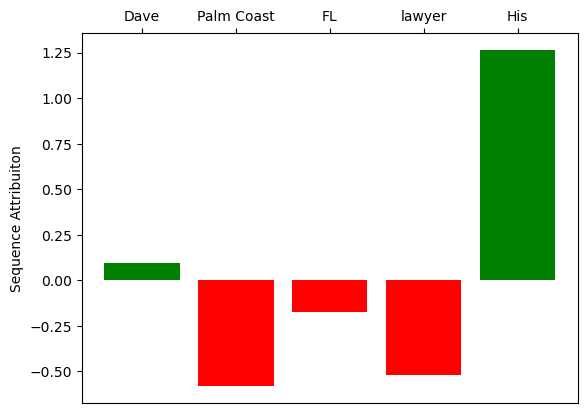

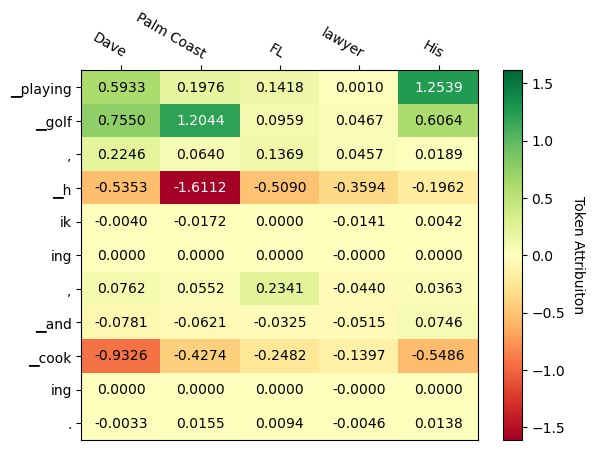

In [256]:
attr_viz = LLMAttrViz(**attr_result)
print(attr_viz.seq_attr_dict)
attr_viz.plot_seq_attr()
attr_viz.plot_token_attr()

We can also perform a similar attribution experiment with a dictionary of inputs / baselines. Additionally, we omit the attribution target, so we will attribute w.r.t what the model will generate in the default setting. As we can see, the result is generally more positive than above. This is expected, since the target, "playing guitar, hiking, and spending time with his family.", is what the model feel confident to generate given the input tokens.

In [452]:
inp_feature = TextTemplateFeature(
    "{name} lives in {city}, {state} and is a {occupation}. {pronoun} personal interests include", 
   inputs={"name":"Dave", "city": "Palm Coast", "state": "FL", "occupation":"lawyer", "pronoun":"His"}, 
   baselines={"name":"Sarah", "city": "Seattle", "state": "WA", "occupation":"doctor", "pronoun":"Her"}
)


attr_result_2 = llm_attr.attribute(inp_feature)

<s> Dave lives in Palm Coast, FL and is a lawyer. His personal interests include
playing guitar, hiking, and spending time with his family. [prob: 0.0009605777449905872 ]
<s> Sarah lives in Palm Coast, FL and is a lawyer. His personal interests include
playing guitar, hiking, and spending time with his family. [prob: 2.644512824190315e-05 ]
<s> Dave lives in Seattle, FL and is a lawyer. His personal interests include
playing guitar, hiking, and spending time with his family. [prob: 0.00028119259513914585 ]


KeyboardInterrupt: 

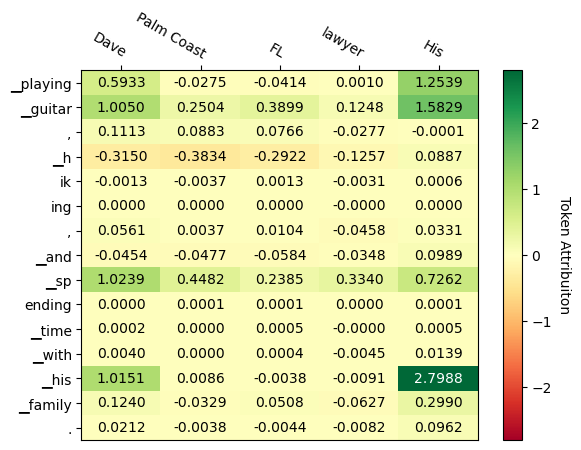

In [222]:
attr_viz_2 = LLMAttrViz(**attr_result_2)
attr_viz_2.plot_token_attr()

Another way to ablate the input text is to directly remove the corresponding tokens, which can also be viewed as replacing them with emptry string. This is also the default baselines for `TextTemplateFeature`. Let's try this, but please note removing tokens is likely to create out-of-distribution text input and therefore may not give you meaningful results.

In [442]:
target = "playing golf, hiking, and cooking."

inp_feature = TextTemplateFeature(
    "{name} lives in {city}, {state} and is a {occupation}. {pronoun} personal interests include", 
   inputs={"name":"Dave", "city": "Palm Coast", "state": "FL", "occupation":"lawyer", "pronoun":"His"}, 
)

attr_result_3 = llm_attr.attribute(inp_feature, target=target)

<s> Dave lives in Palm Coast, FL and is a lawyer. His personal interests include
playing golf, hiking, and cooking. [prob: 1.934102692757733e-05 ]


KeyboardInterrupt: 

{'Dave': 0.09586238861083984, 'Palm Coast': -0.5810728073120117, 'FL': -0.17151927947998047, 'lawyer': -0.519902229309082, 'His': 1.2632627487182617}


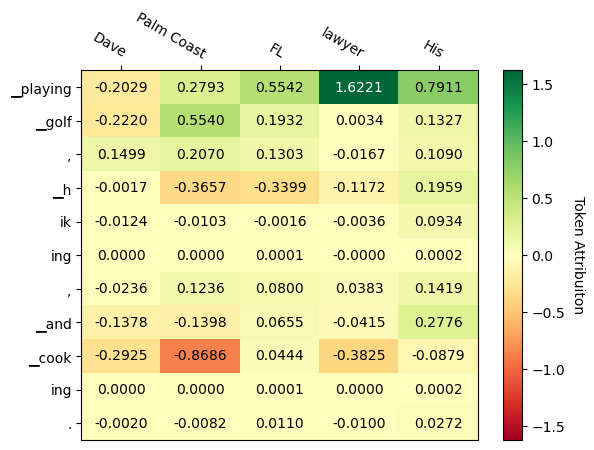

In [274]:
attr_viz_3 = LLMAttrViz(**attr_result_3)
print(attr_viz.seq_attr_dict)
attr_viz_3.plot_token_attr()

One issue we notice from the test results is that there are correlated aspects of the prompt which should be ablated together to ensure that the input remain in distribution, e.g. Palm Coast, FL should be ablated with Seattle, WA. We can accomplish this using a mask as defined below, which will group (city, state) and (name, pronoun)

Dave lives in Palm Coast, FL and is a lawyer. His personal interests include
playing golf, hiking, and cooking. [prob: 1.934102692757733e-05 ]
Sarah lives in Palm Coast, FL and is a lawyer. Her personal interests include
playing golf, hiking, and cooking. [prob: 9.746541763888672e-06 ]
Dave lives in Seattle, WA and is a lawyer. His personal interests include
playing golf, hiking, and cooking. [prob: 3.7795736716361716e-05 ]
Dave lives in Palm Coast, FL and is a doctor. His personal interests include
playing golf, hiking, and cooking. [prob: 3.25289620377589e-05 ]


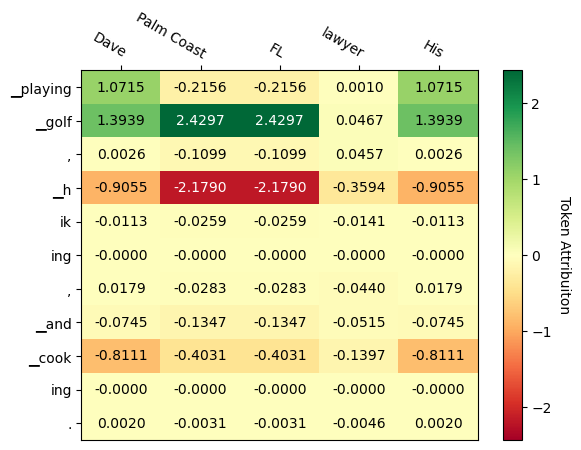

In [278]:
inp_feature = TextTemplateFeature(
    "{name} lives in {city}, {state} and is a {occupation}. {pronoun} personal interests include", 
    inputs={"name":"Dave", "city": "Palm Coast", "state": "FL", "occupation":"lawyer", "pronoun":"His"}, 
    baselines={"name":"Sarah", "city": "Seattle", "state": "WA", "occupation":"doctor", "pronoun":"Her"},
    mask={"name":0, "city": 1, "state": 1, "occupation": 2, "pronoun": 0},
)

attr_result_4 = llm_attr.attribute(
    inp_feature, 
    target=target,
)

attr_viz_4 = LLMAttrViz(**attr_result_4)
attr_viz_4.plot_token_attr()

We have only chosen one baseline, but ideally, we could define a distribution of baselines so the attribution method will sample from it for perturbations. Here, we define a list of baselines with `IterableBaselines` and specify `num_trials` in `attribute` to average over multiple trials 

In [281]:
baselines = IterableBaselines([
    {"name":"Sarah", "city": "Seattle", "state": "WA", "occupation":"doctor", "pronoun":"Her"},
    {"name":"John", "city": "Boston", "state": "MA", "occupation":"engineer", "pronoun":"His"},
    {"name":"Martin", "city": "Menlo Park", "state": "CA", "occupation":"teacher", "pronoun":"His"},
    {"name":"Rachel", "city": "New York", "state": "NY", "occupation":"plumber", "pronoun":"Her"},
])

inp_feature = TextTemplateFeature(
    "{name} lives in {city}, {state} and is a {occupation}. {pronoun} personal interests include", 
    inputs={"name":"Dave", "city": "Palm Coast", "state": "FL", "occupation":"lawyer", "pronoun":"His"},
    baselines=baselines,
    mask={"name":0, "city": 1, "state": 1, "occupation": 2, "pronoun": 0},
)

attr_result_5 = llm_attr.attribute(
    inp_feature, 
    target=target,
    num_trials=10,
)

Dave lives in Palm Coast, FL and is a lawyer. His personal interests include
playing golf, hiking, and cooking. [prob: 1.934102692757733e-05 ]
Martin lives in Palm Coast, FL and is a lawyer. His personal interests include
playing golf, hiking, and cooking. [prob: 2.407893043709919e-05 ]
Dave lives in Seattle, WA and is a lawyer. His personal interests include
playing golf, hiking, and cooking. [prob: 3.7795736716361716e-05 ]
Dave lives in Palm Coast, FL and is a teacher. His personal interests include
playing golf, hiking, and cooking. [prob: 1.4292467312770896e-05 ]
Dave lives in Palm Coast, FL and is a lawyer. His personal interests include
playing golf, hiking, and cooking. [prob: 1.934102692757733e-05 ]
Martin lives in Palm Coast, FL and is a lawyer. His personal interests include
playing golf, hiking, and cooking. [prob: 2.407893043709919e-05 ]
Dave lives in Menlo Park, CA and is a lawyer. His personal interests include
playing golf, hiking, and cooking. [prob: 0.00012078624422429

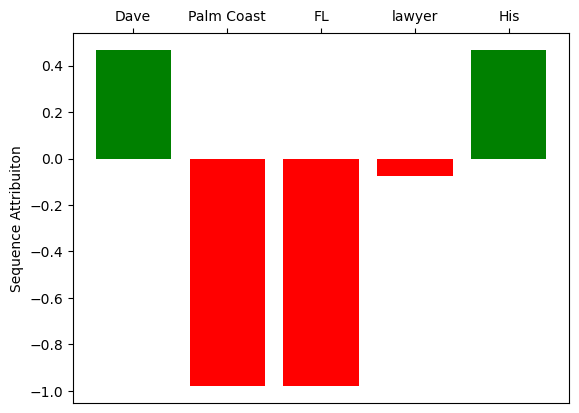

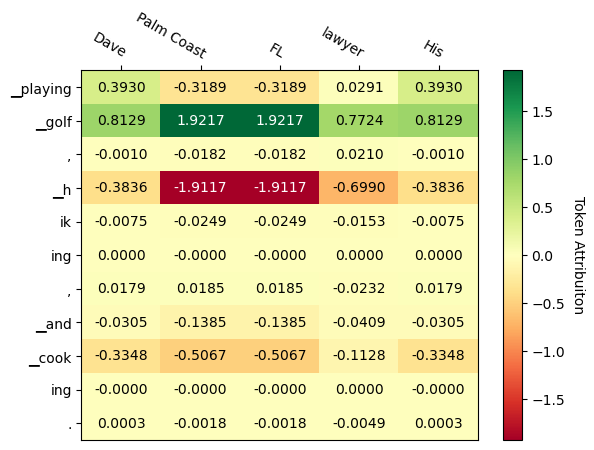

In [282]:
attr_viz_5 = LLMAttrViz(**attr_result_5)
attr_viz_5.plot_seq_attr()
attr_viz_5.plot_token_attr()

We can also independently define the baseline distribution of each attribute with `ProductBaselines`.

In [287]:
baselines = ProductBaselines(
    {
        "name":["Sarah", "John", "Martin", "Rachel"],
        "city": ["Seattle", "Boston"], "state": ["WA", "MA"], 
        "occupation": ["doctor", "engineer", "teacher", "technician", "plumber"], 
        "pronoun":["Her", "His", "His", "Her"]
    }
)

inp_feature = TextTemplateFeature(
    "{name} lives in {city}, {state} and is a {occupation}. {pronoun} personal interests include", 
    inputs={"name":"Dave", "city": "Palm Coast", "state": "FL", "occupation":"lawyer", "pronoun":"His"},
    baselines=baselines,
    mask={"name":0, "city": 1, "state": 1, "occupation": 2, "pronoun": 0},
)

attr_result_6 = llm_attr.attribute(
    inp_feature, 
    target=target,
    num_trials=10,
)

Dave lives in Palm Coast, FL and is a lawyer. His personal interests include
playing golf, hiking, and cooking. [prob: 1.934102692757733e-05 ]
John lives in Palm Coast, FL and is a lawyer. Her personal interests include
playing golf, hiking, and cooking. [prob: 7.725796422164422e-06 ]
Dave lives in Boston, WA and is a lawyer. His personal interests include
playing golf, hiking, and cooking. [prob: 1.5982268450898118e-06 ]
Dave lives in Palm Coast, FL and is a teacher. His personal interests include
playing golf, hiking, and cooking. [prob: 1.4292467312770896e-05 ]
Dave lives in Palm Coast, FL and is a lawyer. His personal interests include
playing golf, hiking, and cooking. [prob: 1.934102692757733e-05 ]
Rachel lives in Palm Coast, FL and is a lawyer. Her personal interests include
playing golf, hiking, and cooking. [prob: 3.987407581007574e-06 ]
Dave lives in Boston, WA and is a lawyer. His personal interests include
playing golf, hiking, and cooking. [prob: 1.5982268450898118e-06 ]
D

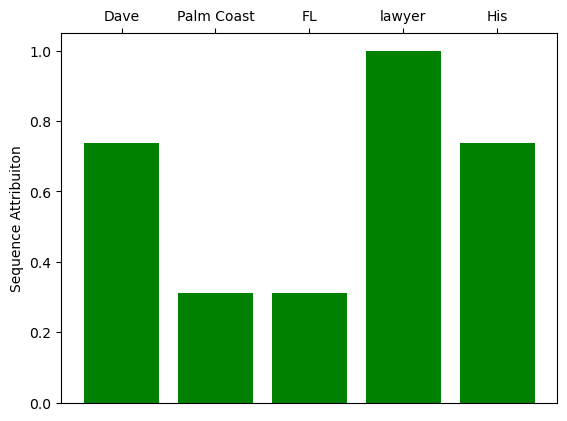

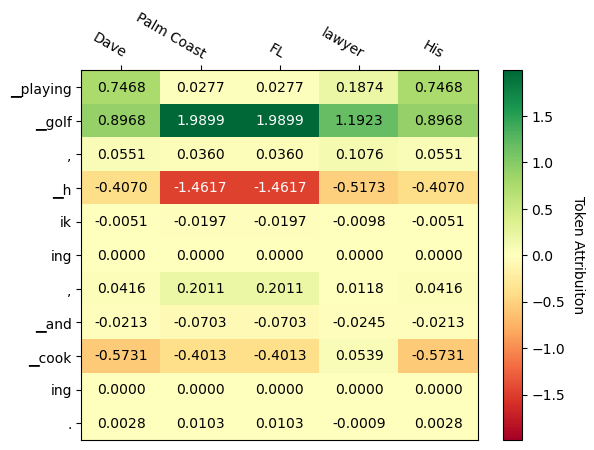

In [292]:
attr_viz_6 = LLMAttrViz(**attr_result_6)
attr_viz_6.plot_seq_attr()
attr_viz_6.plot_token_attr()

One potential issue with the current approach is using Feature Ablation. If the model learns complex interations between the prompt features, the true importance may not be reflected in the attributio scores. Consider a case where the model predicts a high probability of playing golf if a person is either a lawyer or lives in Palm Coast. By ablating a feature one at a time, the probability may appear to be unchanged when ablating each feature independently, but may drop substantially when perturbing both together.

To address this, we can apply alternate perturbation-based attribution methods available in Captum such as ShapleyValueSampling, KernelShap and Lime, which ablate different subgroups of features and may result in more accurate scores.

In [290]:
from captum.attr import ShapleyValueSampling

svs = ShapleyValueSampling(model) 
baselines = ProductBaselines(
    {
        "name":["Sarah", "John", "Martin", "Rachel"],
        "city": ["Seattle", "Boston"], "state": ["WA", "MA"], 
        "occupation": ["doctor", "engineer", "teacher", "technician", "plumber"], 
        "pronoun":["Her", "His", "His", "Her"]
    }
)

inp_feature = TextTemplateFeature(
    "{name} lives in {city}, {state} and is a {occupation}. {pronoun} personal interests include", 
    inputs={"name":"Dave", "city": "Palm Coast", "state": "FL", "occupation":"lawyer", "pronoun":"His"},
    baselines=baselines,
    mask={"name":0, "city": 1, "state": 1, "occupation": 2, "pronoun": 0},
)

llm_attr = LLMAttribution(svs, tokenizer)

inp_feature = TextTemplateFeature(
    "{name} lives in {city}, {state} and is a {occupation}. {pronoun} personal interests include", 
    inputs={"name":"Dave", "city": "Palm Coast", "state": "FL", "occupation":"lawyer", "pronoun":"His"},
    baselines=baselines,
    mask={"name":0, "city": 1, "state": 1, "occupation": 2, "pronoun": 0},
)


attr_result_7 = llm_attr.attribute(
    inp_feature, 
    target=target,
    num_trials=2,
    n_samples=3  # arg to ShapleyValueSampling.attribute
)

Sarah lives in Boston, WA and is a engineer. Her personal interests include
playing golf, hiking, and cooking. [prob: 3.6855415146419546e-06 ]
Martin lives in Palm Coast, FL and is a technician. His personal interests include
playing golf, hiking, and cooking. [prob: 2.18204968405189e-06 ]
Dave lives in Palm Coast, FL and is a doctor. His personal interests include
playing golf, hiking, and cooking. [prob: 3.25289620377589e-05 ]
Dave lives in Palm Coast, FL and is a lawyer. His personal interests include
playing golf, hiking, and cooking. [prob: 1.934102692757733e-05 ]
John lives in Palm Coast, FL and is a plumber. His personal interests include
playing golf, hiking, and cooking. [prob: 5.949759270151844e-06 ]
Dave lives in Palm Coast, FL and is a doctor. His personal interests include
playing golf, hiking, and cooking. [prob: 3.25289620377589e-05 ]
Dave lives in Palm Coast, FL and is a lawyer. His personal interests include
playing golf, hiking, and cooking. [prob: 1.934102692757733e-

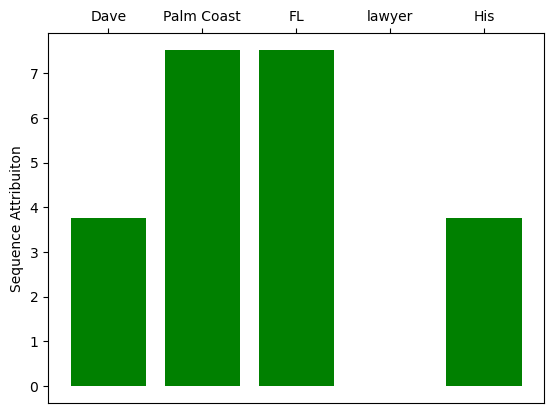

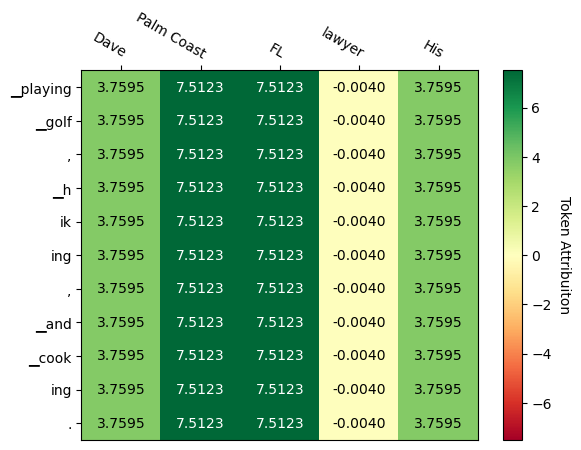

In [293]:
attr_viz_7 = LLMAttrViz(**attr_result_7)
attr_viz_7.plot_seq_attr()
attr_viz_7.plot_token_attr()

Let's now consider a more complex example, where we use the LLM as a few-shot learner to classify sample movie reviews as positive or negative. We apply FeatureAblation to measure the relative impact of the few shot examples. Since the prompt changes slightly in the case that no examples are needed, we define a prompt function rather than a format string in this case.

In [333]:
def prompt_fn(*examples):
    main_prompt = "Decide if the following movie review enclosed in quotes is Positive or Negative:\n'I really liked the Avengers, it had a captivating plot!'\nReply only Positive or Negative."
    subset = [elem for elem in examples if elem is not None]
    if len(subset) == 0:
        return main_prompt
    prefix = "Here are some examples of movie reviews and classification of whether they were Positive or Negative:\n"
    return "[INST] " + prefix + " \n".join(subset) + "\n " + main_prompt + "[/INST]"

In [334]:
llm_attr = LLMAttribution(fa, tokenizer)

input_examples = [
    "'The movie was ok, the actors weren't great' Negative", 
    "'I loved it, it was an amazing story!' Positive",
    "'Total waste of time!!' Negative", 
    "'Won't recommend' Negative",
]
inp_feature = TextTemplateFeature(
    prompt_fn, 
    inputs=input_examples,
)

attr_result_8 = llm_attr.attribute(
    inp_feature,  
#     target="Positive"
)

[INST] Here are some examples of movie reviews and classification of whether they were Positive or Negative:
'The movie was ok, the actors weren't great' Negative 
'I loved it, it was an amazing story!' Positive 
'Total waste of time!!' Negative 
'Won't recommend' Negative
 Decide if the following movie review enclosed in quotes is Positive or Negative:
'I really liked the Avengers, it had a captivating plot!'
Reply only Positive or Negative.[/INST]
 Positive. [prob: 0.5525419116020203 ]
[INST] Here are some examples of movie reviews and classification of whether they were Positive or Negative:
 
'I loved it, it was an amazing story!' Positive 
'Total waste of time!!' Negative 
'Won't recommend' Negative
 Decide if the following movie review enclosed in quotes is Positive or Negative:
'I really liked the Avengers, it had a captivating plot!'
Reply only Positive or Negative.[/INST]
 Positive. [prob: 0.48403507471084595 ]
[INST] Here are some examples of movie reviews and classification 

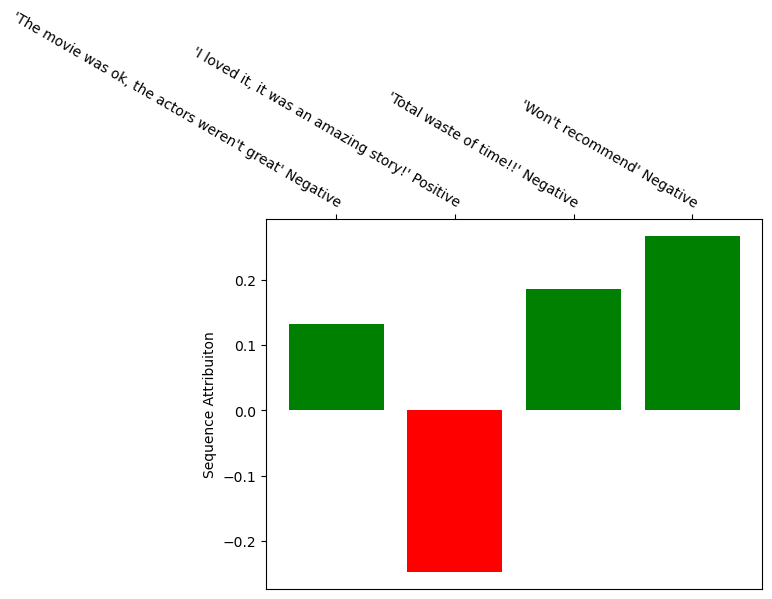

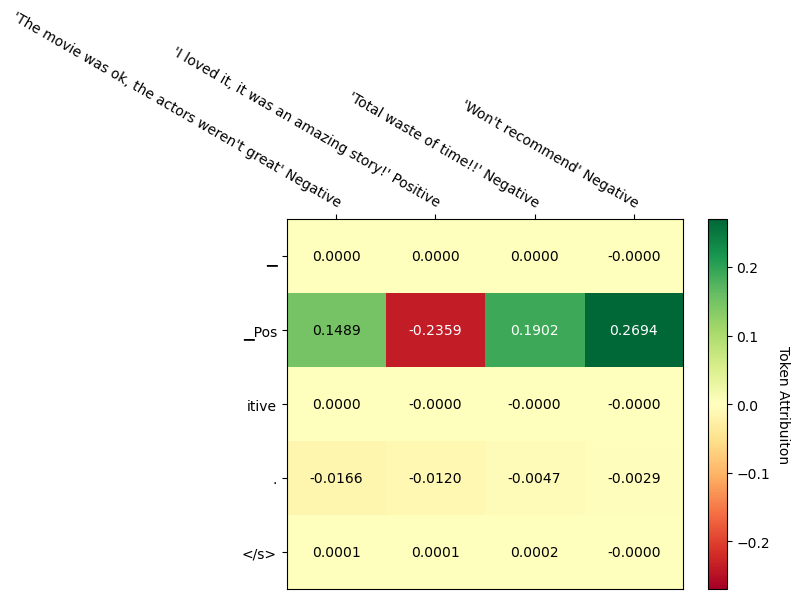

In [339]:
attr_viz_8 = LLMAttrViz(**attr_result_8)
attr_viz_8.plot_seq_attr()
attr_viz_8.plot_token_attr()

In [405]:
llm_attr = LLMAttribution(fa, tokenizer)

inp_feature = TextTokenFeature(
    "Dave lives in Palm Coast, FL and is a lawyer. His personal interests include", 
    tokenizer,
    baselines=0,  # UNK
    skip_tokens=[1],  # <s>
)

attr_result_9 = llm_attr.attribute(inp_feature, target="playing golf, hiking, and cooking.")

<s> Dave lives in Palm Coast, FL and is a lawyer. His personal interests include
playing golf, hiking, and cooking. [prob: 1.934102692757733e-05 ]
<s><unk> lives in Palm Coast, FL and is a lawyer. His personal interests include
playing golf, hiking, and cooking. [prob: 1.9094561139354482e-05 ]
<s> Dave<unk> in Palm Coast, FL and is a lawyer. His personal interests include
playing golf, hiking, and cooking. [prob: 3.641148168753716e-06 ]
<s> Dave lives<unk> Palm Coast, FL and is a lawyer. His personal interests include
playing golf, hiking, and cooking. [prob: 3.978511813329533e-06 ]
<s> Dave lives in<unk>m Coast, FL and is a lawyer. His personal interests include
playing golf, hiking, and cooking. [prob: 2.6035468181362376e-06 ]
<s> Dave lives in Pal<unk> Coast, FL and is a lawyer. His personal interests include
playing golf, hiking, and cooking. [prob: 5.203700766287511e-06 ]
<s> Dave lives in Palm<unk>, FL and is a lawyer. His personal interests include
playing golf, hiking, and cook

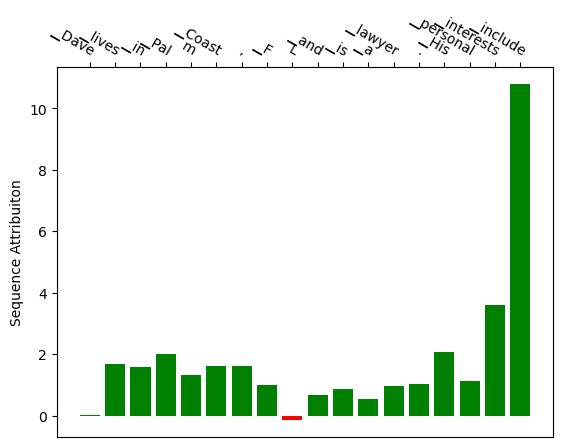

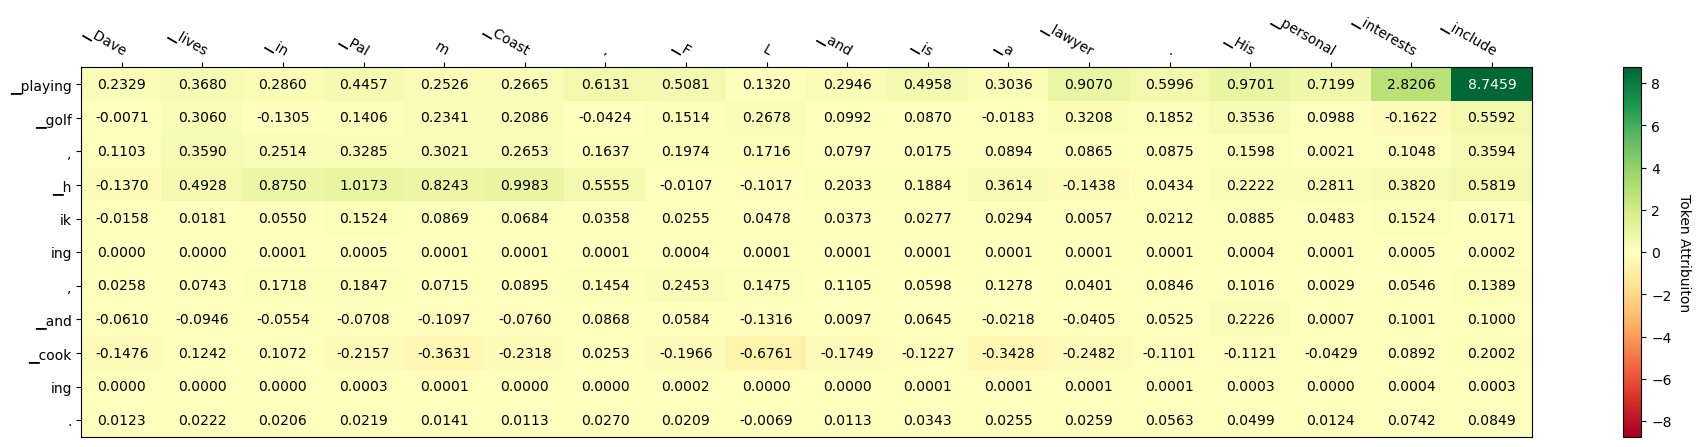

In [406]:
attr_viz_9 = LLMAttrViz(**attr_result_9)
attr_viz_9.plot_seq_attr()
attr_viz_9.plot_token_attr()

In [409]:
emb_layer = model.get_submodule("model.embed_tokens")

In [494]:
class LLMGradientAttribution(Attribution):
    def __init__(
        self, 
        attr_method, 
        tokenizer,
        max_new_tokens=15,
        attr_type: str = "log_prob",  # or prob
    ):
        """
        attr_method: gradients attribution instance crteated with a llm model huggingface style interface
        tokenizer: required
        """
#         assert (
#             type(attr_method) in SUPPORTED_METHODS
#         ), f"LLMAttribution does not support {type(attr_method)}"

        super().__init__(attr_method.forward_func)

        # shallow copy is enough to avoid modifying original instance
        self.attr_method = copy(attr_method)

        self.attr_method.forward_func = self._forward_func
        
        # alias
        self.model = self.forward_func
        
        self.tokenizer = tokenizer
        self.device = self.model.device
        
        # only when attr target is not given
        self.max_new_tokens = max_new_tokens
        
        self.attr_type = attr_type
        
        
    def _forward_func(self, perturbed_feature, input_feature, output_tokens, target_token):
        perturbed_input = self._format_model_input(input_feature.to_model_input(perturbed_feature))
#         print("perturbed_feature", perturbed_feature)
#         print("perturbed_input", perturbed_input.shape)
#         print("output_token_tensor", output_token_tensor.shape)
        
        if output_tokens:
            output_token_tensor = torch.tensor([output_tokens] * perturbed_input.size(0), device=self.device)           
            new_input_tensor = torch.cat([perturbed_input, output_token_tensor], dim=1)
        else:
            new_input_tensor = perturbed_input
                
        output_logits = self.model(new_input_tensor)
    
        new_token_logits = output_logits.logits[:, -1]
        log_probs = torch.nn.functional.log_softmax(new_token_logits, dim=1)
        
        token_log_probs = log_probs[..., target_token]
        print("log_probs", token_log_probs)
        return token_log_probs
    
    
    def _format_model_input(self, model_input):
        """
        Convert str to tokenized tensor
        """
        return model_input.to(self.device)
    
    def attribute(
        self, 
        input_feature: Union["TextFeature", "IdFeature"], 
        target: Union[str, torch.Tensor, None] = None, 
#         num_trials: int = 1, 
#         log_trials=True,
        **kwargs,
    ):
        if type(target) is str:
            # exclude sos
            target_tokens = self.tokenizer.encode(target)[1:]
        elif type(target) is torch.Tensor:
            target_tokens = target
        else:
            # generate when None
            model_inp = self._format_model_input(input_feature.to_model_input())
            output_tokens = self.model.generate(model_inp, max_new_tokens=self.max_new_tokens)
            target_tokens = output_tokens[0][model_inp.size(1):]
        
        init_model_inp = input_feature.interpretable_tensor.to(self.device)
            
        model_inp = init_model_inp
        
        log_prob_list = []
        
        attr_list = []
        output_tokens = []
        for target_token in target_tokens:            
            # attr in shape(batch_size, input+output_len, emb_dim)
            attr = self.attr_method.attribute(
                model_inp,
#                 target=target_token,
                additional_forward_args=(input_feature, output_tokens, target_token),
                **kwargs,
            )
            
#             print(attr.shape)
            
            # the author uses sum 
            # https://github.com/ankurtaly/Integrated-Gradients/blob/master/BertModel/bert_model_utils.py#L350
            attr = attr.sum(-1)
                        
            # we may have the attr for previous output tokens, how to use them?
            if output_tokens:
                attr = attr[..., :-len(output_tokens)]

            attr_list.append(attr)
            
            output_tokens.append(target_token)
            
            
            
        # assume inp batch only has one instance
        attr = torch.cat(attr_list, dim=0)
        
        if isinstance(input_feature, TextTokenFeature) and input_feature.interpretable_mask is not None:
            interpretable_mask = input_feature.interpretable_mask.to(self.device)
            interpretable_mask = interpretable_mask.expand_as(attr)
            attr = attr[interpretable_mask].view(attr.size(0), -1)
                              
        return {
            "seq_attr": None,  # TODO
            "token_attr": attr,  # shape(n_output_token, n_input_features)
            "input_tokens": input_feature.inputs,
            "output_tokens": self.tokenizer.convert_ids_to_tokens(target_tokens)
        }


In [497]:
lig = LayerIntegratedGradients(model, emb_layer)
llm_grad_attr = LLMGradientAttribution(lig, tokenizer)

inp_feature = TextTokenFeature(
    "Dave lives in Palm Coast, FL and is a lawyer. His personal interests include", 
    tokenizer,
    baselines=0,  # UNK
    skip_tokens=[1],
)

attr_result_10 = llm_grad_attr.attribute(inp_feature)

log_probs tensor([-2.0709], device='cuda:0')
log_probs tensor([-9.4683], device='cuda:0')
log_probs tensor([ -9.5406,  -9.6553,  -9.9278, -10.4854, -10.8005, -10.2532, -10.1805,
        -14.0455, -12.1830, -11.2045,  -9.9975, -11.8878, -12.6220, -11.6448,
        -11.8720, -10.7416, -10.0644,  -9.1234,  -3.4986,  -3.2085,  -3.0359,
         -3.0088,  -2.6658,  -2.2921,  -2.1588,  -2.1595,  -2.2699,  -2.2817,
         -2.3294,  -2.3406,  -2.3513,  -2.3412,  -2.3305,  -2.2634,  -2.2051,
         -2.1849,  -2.1575,  -2.1481,  -2.1430,  -2.1222,  -2.1132,  -2.1002,
         -2.0928,  -2.0770,  -2.0843,  -2.0725,  -2.0786,  -2.0701,  -2.0715,
         -2.0661], device='cuda:0', grad_fn=<SelectBackward0>)
log_probs tensor([-0.9615], device='cuda:0')
log_probs tensor([-5.6482], device='cuda:0')
log_probs tensor([-5.6477, -5.6869, -5.7107, -5.8108, -5.9896, -6.2228, -6.4274, -8.7211,
        -4.8410, -4.5691, -5.5906, -5.6740, -7.5825, -7.0264, -8.0953, -8.7098,
        -7.6135, -4.3560, -2.24

log_probs tensor([-0.0596], device='cuda:0')
log_probs tensor([-1.3381], device='cuda:0')
log_probs tensor([-1.3258, -1.3262, -1.3034, -1.2795, -1.2711, -1.2623, -1.2526, -0.6327,
        -1.2945, -1.1639, -1.4952, -1.4264, -1.2434, -1.5907, -1.3319, -1.5639,
        -1.7715, -0.5916, -0.1001, -0.0836, -0.0882, -0.1100, -0.1221, -0.1155,
        -0.1154, -0.1160, -0.1157, -0.0908, -0.0812, -0.0789, -0.0798, -0.0801,
        -0.0825, -0.0757, -0.0720, -0.0719, -0.0677, -0.0686, -0.0676, -0.0655,
        -0.0635, -0.0625, -0.0615, -0.0606, -0.0605, -0.0587, -0.0596, -0.0596,
        -0.0587, -0.0587], device='cuda:0', grad_fn=<SelectBackward0>)
log_probs tensor([-0.2075], device='cuda:0')
log_probs tensor([-0.0851], device='cuda:0')
log_probs tensor([-0.0853, -0.0894, -0.0916, -0.0980, -0.0998, -0.0969, -0.0868, -0.1488,
        -0.0432, -0.1149, -0.0989, -0.1055, -0.1507, -0.1588, -0.1008, -0.1406,
        -0.0902, -0.1292, -0.1662, -0.1209, -0.1293, -0.1515, -0.1912, -0.1328,
        -

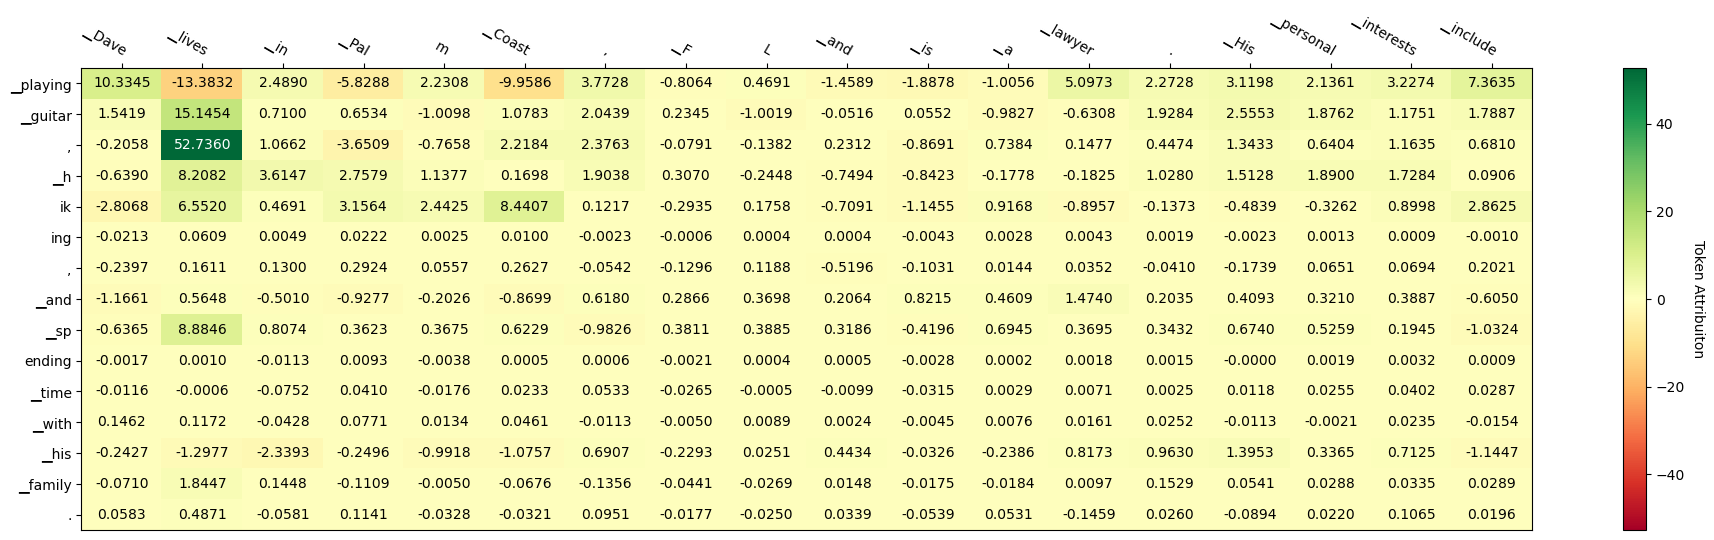

In [498]:
attr_viz_10 = LLMAttrViz(**attr_result_10)
attr_viz_10.plot_token_attr()

In [503]:
inp_feature = TextTokenFeature(
    "Both Canada and France are beautiful countries. Their capitals are", 
    tokenizer,
    baselines=0,  # UNK
    skip_tokens=[1],
)

attr_result_11 = llm_grad_attr.attribute(inp_feature, target="Ottawa and Paris.")

log_probs tensor([-1.6702], device='cuda:0')
log_probs tensor([-11.6209], device='cuda:0')
log_probs tensor([-11.6196, -13.1850, -13.6289, -11.8115, -10.9584, -10.8725, -10.8887,
        -11.0517, -12.4454, -12.3448, -11.4665, -13.3972, -12.4931, -10.5451,
        -11.7205, -11.8162, -11.2747, -10.8822, -11.5802, -10.8118,  -7.8154,
         -7.5461,  -8.7099,  -8.8438,  -6.2957,  -0.9970,  -0.4526,  -0.4897,
         -0.5069,  -0.5451,  -0.6533,  -0.7891,  -0.9134,  -0.9663,  -1.0652,
         -1.1914,  -1.2986,  -1.4371,  -1.5030,  -1.5316,  -1.5561,  -1.5857,
         -1.5955,  -1.5967,  -1.6409,  -1.6452,  -1.6422,  -1.6383,  -1.6367,
         -1.6722], device='cuda:0', grad_fn=<SelectBackward0>)
log_probs tensor([-0.0028], device='cuda:0')
log_probs tensor([-9.7633], device='cuda:0')
log_probs tensor([-9.6995e+00, -9.7178e+00, -9.6750e+00, -9.6096e+00, -9.5780e+00,
        -9.5400e+00, -9.4322e+00, -8.9115e+00, -3.4575e+00, -2.8064e+00,
        -2.8352e+00, -2.1759e+00, -1.5783e+0

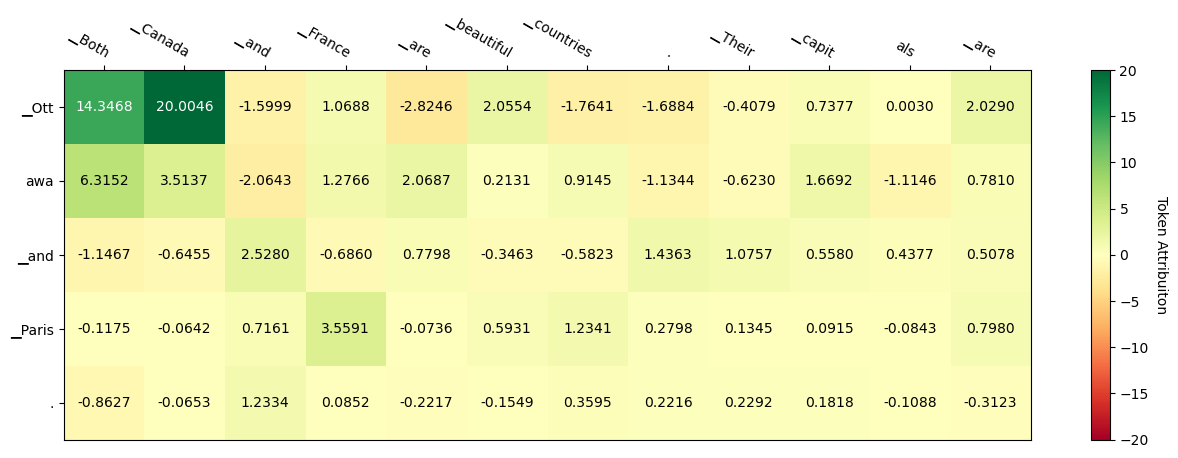

In [504]:
attr_viz_11 = LLMAttrViz(**attr_result_11)
attr_viz_11.plot_token_attr()